# Imports

In [6]:
#no warnings about floating precision
import warnings
warnings.filterwarnings('ignore')

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
# LIMIT GPU MEMORY TAKEN UP BY THE NOTEBOOK
# you can specify the fraction of the AVAILABLE GPU memory that will be
# pre-allocated (jax default is .9)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

#use another GPU if the default one is occupied
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [10]:
import jax
import jax.numpy as np

from jax.random import split, PRNGKey
from jax import lax

jax.config.update('jax_debug_nans', True)

### NOTE: f32 gives > 3x speedup wrt f64
#config.update('jax_enable_x64', True)

#use this line to set the device to be used for the computations
#print(jax.devices())
#DOES NOT RECOGNIZE THE OPTION NAME FTM
#jax.config.update('jax_default_device', jax.devices()[1])

import equinox as eqx

import haiku as hk

from functools import partial

In [11]:
from jax_md import space
import jax_md.dataclasses as jdc

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [12]:
from jax import random, vmap, tree_leaves
from jax_md import space, quantity, util
import jax_md.dataclasses as jdc
from jax_md import space


########## IMPORT JAX-MORPH FUNCTIONS ##########
################################################

from jax_morph.datastructures import SpaceFunc
from jax_morph.utils import _maybe_array, logistic

from jax_morph.simulation import simulation, sim_trajectory

# IMPORT STATE-CHANGING FUNCTIONS
from jax_morph.division_and_growth.cell_division import S_cell_division
from jax_morph.division_and_growth.cell_growth import S_grow_cells

from jax_morph.mechanics.morse import S_mech_morse_relax
from jax_morph.cell_internals.stress import S_set_stress
from jax_morph.chemicals.secdiff import S_ss_chemfield

from jax_morph.cell_internals.divrates import S_set_divrate, div_nn
from jax_morph.cell_internals.secretion import sec_nn
from jax_morph.cell_internals.grad_estimate import S_chemical_gradients
from jax_morph.cell_internals.hidden_state import hidden_state_nn, S_hidden_state

from jax_morph.initial_states import init_state_grow

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate
from Ramya.mech_homogeneous_growth.chemical import S_fixed_chemfield


########## IMPORT PLOTTING UTILITIES ##########
###############################################
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

from functools import partial
import equinox as eqx
import haiku as hk
from tqdm import tqdm


ImportError: cannot import name '_maybe_array' from 'jax_morph.utils' (/n/home10/rdeshpande/.local/lib/python3.8/site-packages/jax_morph-0.1-py3.8.egg/jax_morph/utils.py)

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set Parameters

In [ ]:
#@title Define Params
# Define parameters --blue particles are type 1, orange are type 2
# keep type casting to place vars in gpu memory

# Number of chemical signals
n_chem = 2


### CELL DIMENSIONS
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

# No diffusion or secretion in my simulation - only external chemical field over positions
diffCoeff = np.ones(n_chem) 
degRate = np.ones(n_chem) 

# diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5

# CHEMICAL FIELD
chem_max = 100.0
chem_k = 2.0
chem_gamma = 0.4

### SECRETION

# sec rate that gives concentration 1 at source at SS
#sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = np.ones((n_chem,), dtype=np.float32)
#sec_max = sec_max.at[0].set(10) 
#secreted_by_ctypes = np.ones((n_chem, 1))
ctype_sec_chem = np.ones((1, 2))

# GROWTH


# MORSE POTENTIAL
# always use python scalars
alpha = 3.0
epsilon = 3.
eps_OneOne = 3.
eps_OneTwo = 3.
eps_TwoTwo = 3.

# morse cutoff
r_cutoff = 5.*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for Morse potential minimization
mech_relaxation_steps = 10


# Initialization and number of added cells. 
ncells_init = 10 #number of cells in the initial cluster
ncells_add = 30

hidden_state_size = 8

NameError: name 'np' is not defined

In [ ]:
#@title Define trainable params
train_params = {
    'n_chem': False,
    'n_dim': False,
    'sec_max': True,
    'ctype_sec_chem': False,

    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : True,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'epsilon': False,
    'eps_OneOne': False,
    'eps_OneTwo': False,
    'eps_TwoTwo': False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'ncells_add': False,

    'chem_max': False, 
    'chem_k': False,
    'chem_gamma': False,

    'hidden_state_size': False
}

In [ ]:
#@title Initialize params
params = {
    'n_chem': n_chem,
    'n_dim': 2,
    'sec_max': sec_max,
    'ctype_sec_chem' : ctype_sec_chem,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params), 
    'epsilon':  _maybe_array('epsilon', epsilon, train_params),
    'eps_OneOne': _maybe_array('eps_OneOne', eps_OneOne, train_params),
    'eps_OneTwo': _maybe_array('eps_OneTwo', eps_OneTwo, train_params),
    'eps_TwoTwo': _maybe_array('eps_TwoTwo', eps_TwoTwo, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'ncells_add': ncells_add,

    'chem_max': chem_max,
    'chem_k': chem_k,
    'chem_gamma': chem_gamma,

    'hidden_state_size':  hidden_state_size,

}

NameError: name 'sec_max' is not defined

# Simulation

In [ ]:
# decorator MUST be jax_md.dataclass instead of dataclasses.dataclass
# to make dataclass compatible with jax tree operations
@jdc.dataclass
class CellState:
    '''
    Dataclass containing the system state.

    STATE
    -----

    '''

    # STATE
    position:   util.Array
    celltype:   util.Array
    radius:     util.Array
    chemical:   util.Array
    chemgrad:   util.Array
    field:     util.Array
    stress:   util.Array
    hidden_state: util.Array
    divrate:    util.Array
    key:        util.Array


    @classmethod
    def default_init(cls, n_dim=2, n_chem=1, hidden_size=10):
        '''
        Intializes a CellState with no cells (empty data structures, with correct shapes).
        

        Parameters
        ----------
        n_dim: int
            Number of spatial dimensions.
        n_chem: int
            Number of chemical species.

        Returns
        -------
        CellState
        '''

        assert n_dim == 2 or n_dim == 3, 'n_dim must be 2 or 3'
        assert n_chem > 0 and isinstance(n_chem, int), 'n_chem must be a positive integer'
        
        defaultstate = {
            'position'  :   np.empty(shape=(0, n_dim),              dtype=np.float32),
            'celltype'  :   np.empty(shape=(0,),                    dtype=np.int8),
            'radius'    :   np.empty(shape=(0,),                    dtype=np.float32),
            'chemical'  :   np.empty(shape=(0, n_chem),             dtype=np.float32),
            'chemgrad'  :   np.empty(shape=(0, int(n_dim*n_chem)),  dtype=np.float32),
            'field'   :      np.empty(shape=(0,),                   dtype=np.float32),
            'stress'  :   np.empty(shape=(0,),                      dtype=np.float32), 
            'hidden_state' : np.empty(shape=(0, hidden_size),       dtype=np.float32),
            'divrate'   :   np.empty(shape=(0,),                    dtype=np.float32),
            'key'       :   None,
        }


        return cls(**defaultstate)

NameError: name 'jdc' is not defined

In [ ]:
# build space handling function and initial state
key = random.PRNGKey(0)
fspace = SpaceFunc(*space.free())

N_CELLS_INIT = params['ncells_init']



#generate empty data structure with correct shapes
istate = CellState.default_init(n_dim=params['n_dim'], 
                                n_chem=params['n_chem'],
                                hidden_size=params['hidden_state_size']
                                )

# populate initial state by growing from single cell
key, init_key = random.split(key)
istate = init_state_grow(init_key, istate, params, fspace, N_CELLS_INIT)
# set 20% of the cells to type 2
ctype_indices = random.choice(key, np.arange(params["ncells_init"]), (1, int(params["ncells_init"]/5)))
istate = jdc.replace(istate, celltype=istate.celltype.at[ctype_indices].set(2))

NameError: name 'random' is not defined

In [ ]:
#randomly initialize hidden states
from jax.nn import softplus
key, init_key = random.split(key)
# hidden_regulation_init = 5*jax.random.normal(init_key, shape=istate.hidden_state.shape)
hidden_state_init = softplus(10*(random.uniform(init_key, shape=istate.hidden_state.shape)*2 - 1))
istate = jdc.replace(istate, hidden_state=hidden_state_init)

NameError: name 'random' is not defined

In [ ]:
# randomly initialize chemical species
key, init_key = random.split(key)
ichem = random.uniform(init_key, istate.chemical.shape)*params['sec_max']
istate = jdc.replace(istate, chemical=ichem)

In [ ]:
from jax_morph.mechanics.morse import _generate_morse_params_onetype, _generate_morse_params_twotypes, mechmin_sgd
from jax_md import energy
def S_mech_morse_relax(state, params, fspace, dt=.0001, morse_eps_sigma='onetype', n_steps=None):
    '''
    Minimize mechanical energy with SGD. 
    Energy is given by the Morse potential with parameters calculated for the two-celltypes case.

    morse_eps_sigma:
      'onetype': use the same epsilon for all particles
      'twotypes': use different epsilons for each particle type
      function: a function that returns the epsilon and sigma matrices

    '''

    n_steps = n_steps if n_steps is not None else params['mech_relaxation_steps']

    
    if morse_eps_sigma == 'onetype':
        morse_eps_sigma = _generate_morse_params_onetype
    elif morse_eps_sigma == 'twotypes':
        morse_eps_sigma = _generate_morse_params_twotypes
    #else:
    # it is assumed that morse_eps_sigma is a function that returns the epsilon and sigma matrices

    
    epsilon_matrix, sigma_matrix = morse_eps_sigma(state, params)
    
    energy_morse = energy.morse_pair(fspace.displacement,
                                     alpha=params['alpha'],
                                     epsilon=epsilon_matrix,
                                     sigma=sigma_matrix, 
                                     r_onset=params['r_onset'], 
                                     r_cutoff=params['r_cutoff'])
    
    
    new_position = mechmin_sgd(energy_morse, 
                               state.position, 
                               fspace.shift, 
                               n_steps,
                               dt)
    
    new_state = jdc.replace(state, position=new_position)

    return new_state

In [ ]:
# GENERATE ADHESION FUNCTION WITH NEURAL NETWORK
#input fields to the network
use_state_fields_ad = CellState(position=   False, 
                             celltype=   False, 
                             radius=     False, 
                             chemical=      False,
                             chemgrad=   False,
                             field=      False,
                             stress=   False,
                             divrate=    False,
                             hidden_state= True, 
                             key=        False
                            )
def morse_nn(params, 
           train_params=None, 
           n_hidden=3,
           use_state_fields=use_state_fields_ad,
           train=True,
           eps_min=1.,
           eps_max=3.,
          ):
    
    if type(n_hidden) == np.int_ or type(n_hidden) == int:
        n_hidden = [int(n_hidden)]
    

    
    def _morse_eps_nn(in_fields):
        mlp = hk.nets.MLP(n_hidden+[1],
                          activation=jax.nn.leaky_relu,
                          activate_final=False
                         )
        out = jax.nn.sigmoid(mlp(in_fields))
        return out

    _morse_eps_nn = hk.without_apply_rng(hk.transform(_morse_eps_nn))


    
    def init(state, key):
        
        
        in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
        
        input_dim = in_fields.shape[1]
            
        p = _morse_eps_nn.init(key, np.zeros(input_dim))
        
        #add to param dict
        params['morse_eps_fn'] = p
        params['morse_eps_min'] = eps_min
        params['morse_eps_max'] = eps_max
        
        # no need to update train_params when generating initial state
        if type(train_params) is dict:
            
            #set trainability flag
            train_p = jax.tree_map(lambda x: train, p)

            train_params['morse_eps_fn'] = train_p
            train_params['morse_eps_min'] = train
            train_params['morse_eps_max'] = train
        
            return params, train_params
            
        else:
            return params
            
        
        
    def fwd(state, params):
        
        ### sigma (distance) matrix
        radii = np.array([state.radius]) 
        sigma_matrix = radii+radii.T
        
        ### epsilon (energy scale) matrix
        in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
        
        x = _morse_eps_nn.apply(params['morse_eps_fn'], in_fields)
        x = x*(params['morse_eps_max']-params['morse_eps_min'])+params['morse_eps_min']
        epsilon_matrix = (x+x.T)/2

    
        return epsilon_matrix, sigma_matrix
    
    
    return init, fwd


In [ ]:
#hidden neurons per layer
from jax.nn import tanh
HID_HIDDEN = [8]


#input fields to the network
use_state_fields = CellState(position=      False, 
                             celltype=      True, 
                             radius=            False, 
                             chemical=          True,
                             chemgrad=          True,
                             field=             False,
                             stress=            True,
                             divrate=           False,
                             hidden_state=      False,
                             key=           False
                            )


# init nn functions
hid_init, hid_nn_apply = hidden_state_nn(params,
                                         train_params,
                                         HID_HIDDEN,
                                         use_state_fields,
                                         train=True,
                                         transform_mlp_out=tanh,
                                         )


key, init_key = random.split(key)
params, train_params = hid_init(istate, init_key)

In [ ]:
#hidden neurons per layer
from jax.nn import sigmoid, initializers
DIV_HIDDEN = []


#input fields to the network
use_state_fields_div = CellState(position=   False, 
                             celltype=   False, 
                             radius=     False, 
                             chemical=     False,
                             field=      False,
                             stress=    False,
                             chemgrad=   False,
                             hidden_state= True,
                             divrate=    False, 
                             key=        False
                            )
transform_mlp_out = sigmoid
# init nn functions
div_init, div_nn_apply = div_nn(params,
                                train_params,
                                DIV_HIDDEN,
                                use_state_fields_div,
                                train=True,
                                transform_mlp_out=transform_mlp_out,
                                transform_fwd=None,
                                w_init=initializers.zeros)


#initialize network parameters
key, init_key = random.split(key)
params, train_params = div_init(istate, init_key)

In [ ]:
#hidden neurons per layer
SEC_HIDDEN = []


#input fields to the network
use_state_fields_sec = CellState(position=   False, 
                             celltype=   False, 
                             radius=     False, 
                             chemical=      False,
                             chemgrad=   False,
                             field=      False,
                             stress=   False,
                             divrate=    False,
                             hidden_state= True, 
                             key=        False
                            )


# init nn functions
sec_init, sec_nn_apply = sec_nn(params,
                                train_params,
                                SEC_HIDDEN,
                                use_state_fields_sec,
                                train=True)


#initialize network parameters
key, init_key = random.split(key)
params, train_params = sec_init(istate, init_key)

In [ ]:
# adhesion NN
MORSE_HIDDEN = [10]*3
use_state_fields_ad = CellState(position=   False, 
                             celltype=   False, 
                             radius=     False, 
                             chemical=      False,
                             chemgrad=   False,
                             field=      False,
                             stress=   False,
                             divrate=    False,
                             hidden_state= True, 
                             key=        False
                            )
morse_init, morse_nn_apply = morse_nn(params,train_params,MORSE_HIDDEN,use_state_fields,train=True)


key, init_key = split(key)
params, train_params = morse_init(istate, init_key)

In [ ]:
# functions in this list will be executed in the given order
# at each simulation step

fstep = [
    S_cell_division,
    partial(S_grow_cells, grate=.05),
    partial(S_mech_morse_relax, morse_eps_sigma=morse_nn_apply),
    partial(S_hidden_state, dhidden_fn=eqx.filter_jit(hid_nn_apply), state_decay=.0),
    partial(S_ss_chemfield, sec_fn=sec_nn_apply, n_iter=5),
    S_set_stress,
    partial(S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]
sim_init, sim_step = simulation(fstep, params, fspace)

In [ ]:
key, sim_key = random.split(key)
sim_init, sim_step = simulation(fstep,params, fspace)
fstate, traj = sim_trajectory(istate, sim_init, sim_step, 100, sim_key, history=True)

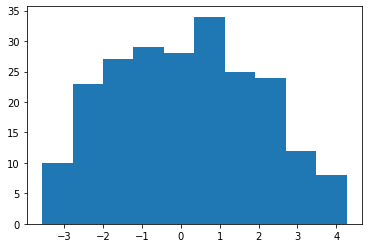

In [ ]:
plt.hist(list(fstate.position.flatten()));

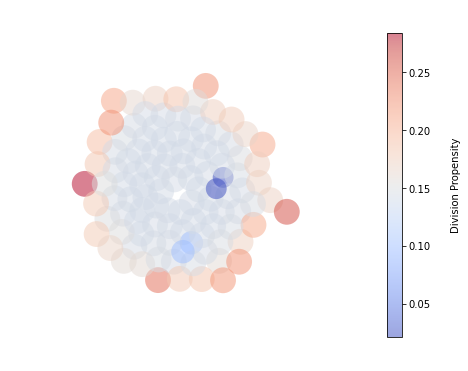

In [ ]:
draw_circles_divrate(fstate);    

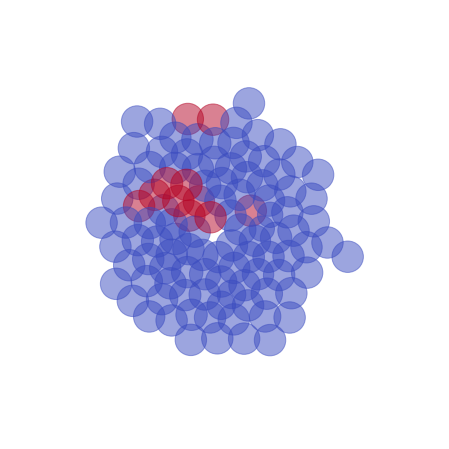

In [ ]:
draw_circles_ctype(fstate);    

In [ ]:
%%time
test(fstate)

CPU times: user 8.39 ms, sys: 0 ns, total: 8.39 ms
Wall time: 8.4 ms


Array(-4.8767436e-08, dtype=float32)

# Optimization

In [ ]:
from jax import vmap, value_and_grad

import optax
from optax import adam, sgd

from jax_morph.optimization.losses import loss, avg_loss

## Shape metrics

In [ ]:
from jax_md.space import pairwise_displacement, distance, map_product
def pairwise_distances(state):
    cells_second_type = np.where(state.celltype == 2, 1, 0)
    mask = (np.atleast_2d(cells_second_type).T*np.atleast_2d(cells_second_type))
    pairwise_dist = distance(map_product(fspace.displacement)(state.position, state.position))
    pairwise_dist_out = np.sum(pairwise_dist*mask)/(np.sum(mask))
    del pairwise_dist, mask, cells_second_type
    return pairwise_dist_out

In [ ]:
def test(state):
    mask = np.where(state.celltype == 2, 1, 0)
    mean_x = np.sum(state.position[:, 0]*mask)/np.sum(mask)
    mean_y = np.sum(state.position[:, 1]*mask)/np.sum(mask)
    metric = np.sum((state.position[:, 0] - mean_x)*mask) + np.sum((state.position[:, 1] - mean_y)*mask)
    metric  = metric/np.sum(mask)
    return metric

## Optimization loop

In [ ]:
from jax import tree_map
from tqdm import tqdm, trange
def train(key, 
          EPOCHS, 
          EPISODES_PER_UPDATE, 
          EPISODES_PER_EVAL, 
          LEARNING_RATE, 
          train_loss, 
          eval_loss,
          fstep, 
          fspace, 
          istate,
          params,
          train_params,
          normalize_grads=False,
          optimizer=optax.adam,
          ):

    p, hp = eqx.partition(params, train_params)

    # init optimizer
    optimizer = optimizer(LEARNING_RATE)
    opt_state = optimizer.init(p)

    #--------------------------------------------
    #store loss at initial params and calc grad 

    key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)

    ll, grads = value_and_grad(avg_loss)(p, hp, train_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)


    key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
    eval_subkeys = np.array(eval_subkeys)

    l = avg_loss(p, hp, eval_loss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    print('Initial loss: {:.4f}'.format(l))
    print(grads)
    #store initial params and loss
    loss_t = [float(l)]
    params_t = [p]
    grads_t = [grads]
    
    #--------------------------------------------
    pbar = np.arange(EPOCHS)
    #pbar = trange(EPOCHS, desc='Loss: {:.4f}'.format(l))
    for t in pbar:
        
        try:
            #generate batch of random keys
            key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
            batch_subkeys = np.array(batch_subkeys)
        
            #normalize grads
            if normalize_grads:
                grads = tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), grads)


            # sgd step
            updates, opt_state = optimizer.update(grads, opt_state, p)

            p = eqx.apply_updates(p, updates)
        
            #clip diffCoeff if trained
            if None != p['diffCoeff']:
                p['diffCoeff'] = np.clip(p['diffCoeff'],.2)
        
            #estimate actual avg loss
            key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
            eval_subkeys = np.array(eval_subkeys)

            l = avg_loss(p, hp, eval_loss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)
        
            # surrogate loss and grads
            ll, grads = value_and_grad(avg_loss)(p, hp, train_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)


            #store
            loss_t += [float(l)]
            params_t += [p]
            grads_t += [grads]
            print("loss: %s" % l)
            #pbar.set_description('Loss: {:.4f}'.format(l))

        except FloatingPointError:
            print('NaN or Overflow')
            break

        except KeyboardInterrupt:
            print('Interrupted')
            break


    return loss_t, params_t, grads_t

In [ ]:
EPOCHS = 2
EPISODES_PER_UPDATE = 1
EPISODES_PER_EVAL = 1

LEARNING_RATE = 0.01
#LEARNING_RATE = optax.piecewise_constant_schedule(1e-3, {50: .3})


############## define loss parameters
METRIC_FN = test #mask_metric(v_mask, 3, -1)  #mask_metric(v_mask, 5, 1) #position_sum_of_squares

train_loss = eqx.filter_jit(partial(loss, metric_fn=METRIC_FN, metric_type='cost', REINFORCE=True))
eval_loss = eqx.filter_jit(partial(loss, metric_fn=METRIC_FN, REINFORCE=False, metric_type='cost'))
##############

key, train_key = random.split(key)
sim_init, sim_step = simulation(fstep, params, fspace)
istate = sim_init(istate, params["ncells_add"], key)

loss_t, params_t, grads_t = train(train_key, 
                                  EPOCHS, 
                                  EPISODES_PER_UPDATE, 
                                  EPISODES_PER_EVAL, 
                                  LEARNING_RATE, 
                                  train_loss, 
                                  eval_loss,
                                  fstep,
                                  fspace,
                                  istate,
                                  params,
                                  train_params,
                                  normalize_grads=False,
                                  optimizer=optax.adam, #yogi #adabelief #rmsprop
                                  )

: 

: 

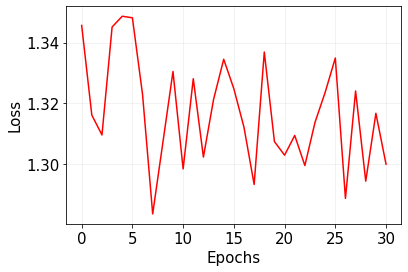

In [27]:
plt.plot(np.array(loss_t), 'r')
#plt.yscale('log')

plt.grid(alpha=.2)


plt.xlabel('Epochs')
plt.ylabel('Loss');

In [25]:
p = params_t[int(np.argmin(np.asarray(loss_t)))]
#p = params_t[-1]

#### Cmp. loss distributions

#### Div nn viz

In [26]:
#### div
def _div_nn(in_fields):
    mlp = hk.nets.MLP(DIV_HIDDEN+[1],
                      activation=jax.nn.leaky_relu,
                      activate_final=False
                     )
    out = jax.nn.sigmoid(mlp(in_fields))
    return out

_div_nn = hk.without_apply_rng(hk.transform(_div_nn))



#### sec
def _sec_nn(in_fields):
    mlp = hk.nets.MLP(SEC_HIDDEN+[params['n_chem']],
                      activation=jax.nn.leaky_relu,
                      activate_final=False
                     )
    out = jax.nn.sigmoid(mlp(in_fields))
    return out

_sec_nn = hk.without_apply_rng(hk.transform(_sec_nn))

In [57]:
xxx, yyy = np.meshgrid(np.linspace(0,2,30), np.linspace(0,2,30))
#xxx, yyy = np.meshgrid(np.linspace(-20,20,30), np.linspace(-20,20,30))

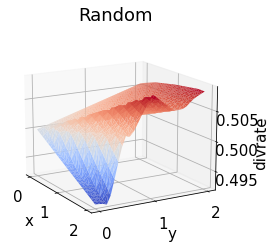

In [58]:
cc = np.vstack((xxx.flatten(),yyy.flatten()))

dd = _div_nn.apply(params['div_fn'], cc.T).flatten()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
surf = ax.plot_trisurf(cc[0], cc[1], dd, linewidth=.1, antialiased=True, shade=False, cmap=plt.cm.coolwarm)

ax.view_init(15, -30)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('divrate')

ax.set_title('Random');

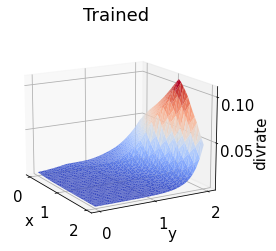

In [59]:
cc = np.vstack((xxx.flatten(),yyy.flatten()))

dd = _div_nn.apply(p['div_fn'], cc.T).flatten()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
surf = ax.plot_trisurf(cc[0], cc[1], dd, linewidth=.1, antialiased=True, shade=False, cmap=plt.cm.coolwarm)

ax.view_init(15, -30)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('divrate')

ax.set_title('Trained');

## Initial params

In [99]:
pp = params.copy()

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, pp, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, ncells_add=90, key=subkey)

print(METRIC_FN(fstate))

0.8195695


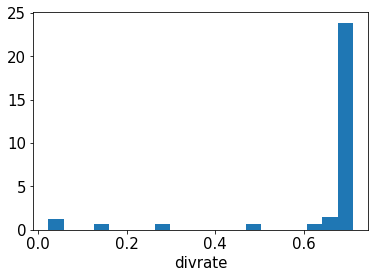

In [100]:
plt.hist(fstate.divrate.tolist(),20,density=True);
plt.xlabel('divrate');

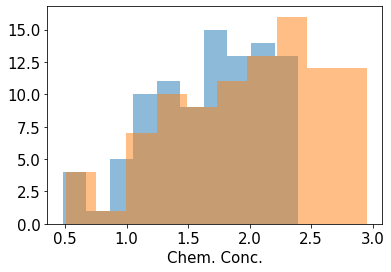

In [101]:
for chem in fstate.chemical.T.tolist():
    plt.hist(chem, alpha=.5);

plt.xlabel('Chem. Conc.');

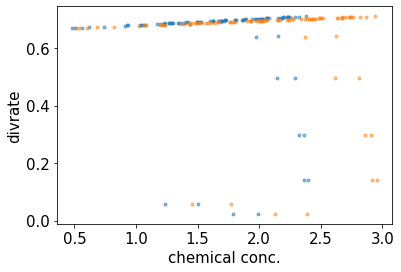

In [102]:
yy = fstate.divrate.tolist()

for chem in fstate.chemical.T.tolist():
    plt.plot(chem, yy, '.', alpha=.5)

plt.ylabel('divrate')
plt.xlabel('chemical conc.');

#plt.legend();

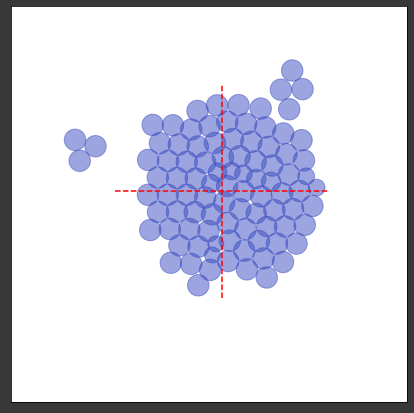

In [103]:
draw_circles_ctype(fstate);

plt.gca().plot([-5.,5.],[0.,0.],'r--');
plt.gca().plot([0.,0.],[-5.,5.],'r--');

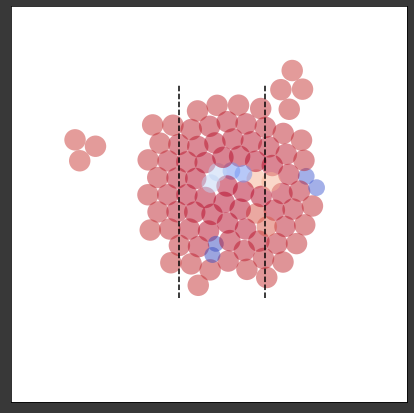

In [104]:
draw_circles_divrate(fstate);

lim = 2.

plt.gca().plot([lim,lim],[-5.,5.],'k--');
plt.gca().plot([-lim,-lim],[-5.,5.],'k--');

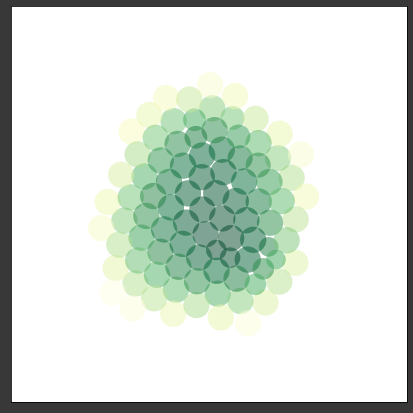

In [56]:
draw_circles_chem(fstate);

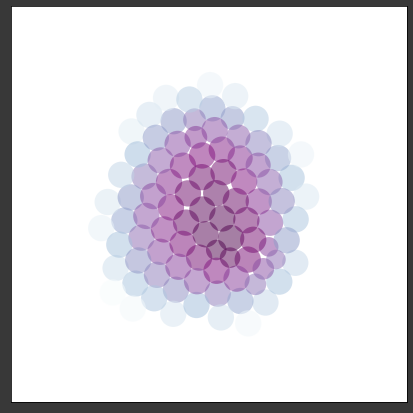

In [57]:
draw_circles_chem(fstate,1);

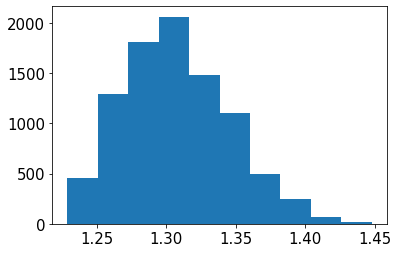

In [105]:
plt.hist(morse_nn_apply(fstate, params)[0].flatten().tolist());

## Trained params

In [28]:
# merge params dicts
all_params = eqx.combine(p, hp)

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, ncells_add=90, key=subkey)



print(METRIC_FN(fstate))

0.8238415


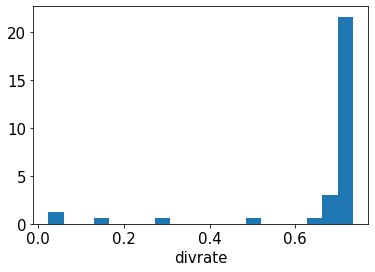

In [29]:
plt.hist(fstate.divrate.tolist(),20,density=True);
plt.xlabel('divrate');

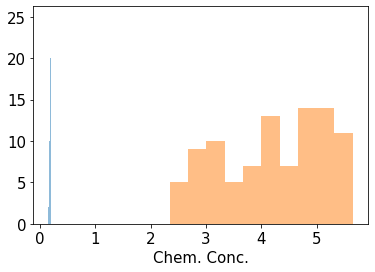

In [30]:
for chem in fstate.chemical.T.tolist():
    plt.hist(chem, alpha=.5);

plt.xlabel('Chem. Conc.');

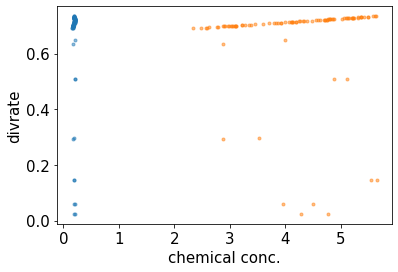

In [31]:
yy = fstate.divrate.tolist()

for chem in fstate.chemical.T.tolist():
    plt.plot(chem, yy, '.', alpha=.5)

plt.ylabel('divrate')
plt.xlabel('chemical conc.');

#plt.legend();

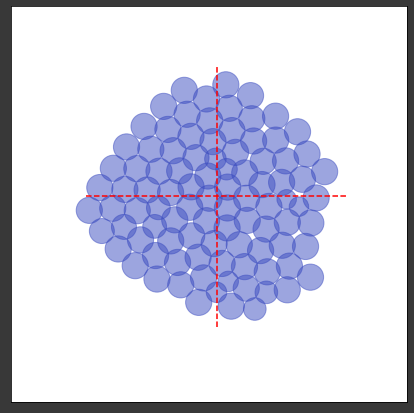

In [32]:
draw_circles_ctype(fstate);
plt.gca().plot([-5.,5.],[0.,0.],'r--');
plt.gca().plot([0.,0.],[-5.,5.],'r--');

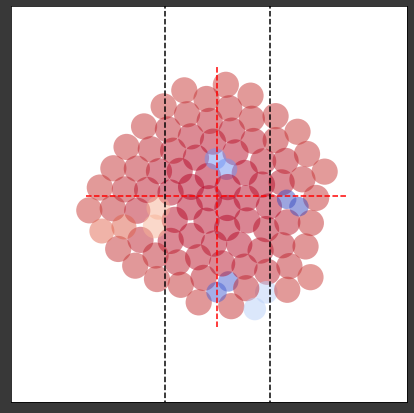

In [40]:
draw_circles_divrate(fstate);


lim = 2.

plt.gca().plot([-5.,5.],[0.,0.],'r--');
plt.gca().plot([0.,0.],[-5.,5.],'r--');

plt.gca().plot([lim,lim],[-15.,15.],'k--');
plt.gca().plot([-lim,-lim],[-15.,15.],'k--');

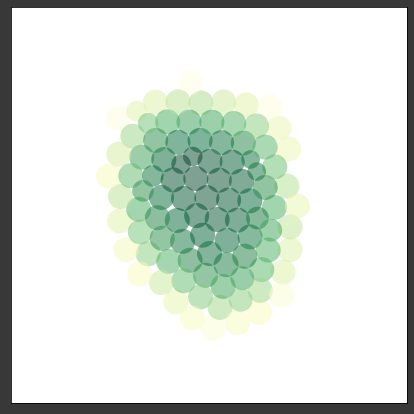

In [112]:
draw_circles_chem(fstate);

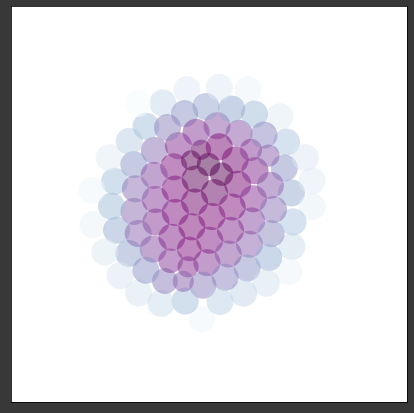

In [66]:
draw_circles_chem(fstate,1);

In [67]:
p['diffCoeff']

DeviceArray([1.2467067, 0.7768229], dtype=float32)

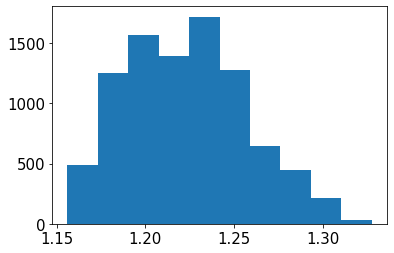

In [34]:
plt.hist(morse_nn_apply(fstate, params)[0].flatten().tolist());

# Metric shape tests

In [370]:
def xmask(state):

    mask = (state.position[:,1] > (state.position[:,0]-1)) * (state.position[:,1] < (state.position[:,0]+1))
    mask = mask + (state.position[:,1] > (-state.position[:,0]-1)) * (state.position[:,1] < (-state.position[:,0]+1))
    
    return np.where(mask,-1.,2)*np.where(state.celltype>0,1,0)

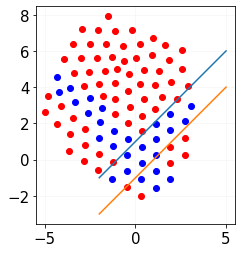

In [371]:
plt.plot(fstate.position[xmask(fstate)>0].T[0].tolist(), fstate.position[xmask(fstate)>0].T[1].tolist(),'ro')
plt.plot(fstate.position[xmask(fstate)<0].T[0].tolist(), fstate.position[xmask(fstate)<0].T[1].tolist(),'bo')

plt.gca().set_aspect('equal')

plt.grid(alpha=.1)

x = np.linspace(-2,5)

plt.plot(x, x+1)
plt.plot(x, x-1);